In [61]:
###We will use qutip this time to obtain the Fig. 1 plot of Khemani et al. 2023

##https://arxiv.org/abs/2305.11940

import qutip as qt
from qutip import *

##Qiskit libraries
import qiskit
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
import qiskit_aer 
from qiskit.quantum_info import state_fidelity
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.circuit.library import Initialize
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt
import sys
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Operator

#scipy
import scipy

In [62]:
Paulis = ['I', 'X', 'Y', 'Z']


N = 2
c = N
str1 = ''
PauliOp_strings=[]

def PauliStrings(N,c,str1):
    if c == 1:
        for k in range(len(Paulis)):
            PauliOp_strings.append(str1 + Paulis[k])
    else:
        for k in range(len(Paulis)):
            PauliStrings(N,c-1,str1+Paulis[k])

def pauli_ops(PauliOp_strings):  ##4^N Pauli operators in Qutip
    '''
    Generate Pauli X,Y,Z operators for a n-qubit system

    INPUT
    PauliOp_strings : list of strings

    RETURN
    op_list : list of qutip operators
    '''

    """for i in range(n_spins):
        sx = qeye_list.copy()
        sy = qeye_list.copy()
        sz = qeye_list.copy()
        sx[i],sy[i],sz[i] = (qt.sigmax(),qt.sigmay(),qt.sigmaz())
        sx_list.append(qt.tensor(sx))
        sy_list.append(qt.tensor(sy))
        sz_list.append(qt.tensor(sz))
    return sx_list,sy_list,sz_list"""
    op_list = []
    for opstr in PauliOp_strings:
        temp_list = opstr.split()
        for k in range(len(temp_list)):
            if temp_list[k] == 'I':
                temp_list[k] = qeye(2)
            elif temp_list[k] == 'X':
                temp_list[k] = sigmax()
            elif temp_list[k] == 'Y':
                temp_list[k] = sigmay()
            elif temp_list[k] == 'Z':
                temp_list[k] = sigmaz()
        op_list.append(tensor(temp_list))
    return op_list
    

def X(i,n):
        """
        X operator on qubit i
        """
        return tensor([sigmax() if j == i else qeye(2) for j in range(n)])
def Y(i,n):
        """
        Y operator on qubit i
        """
        return tensor([sigmay() if j == i else qeye(2) for j in range(n)])
def Z(i,n):
        """
        Z operator on qubit i
        """
        return tensor([sigmaz() if j == i else qeye(2) for j in range(n)])
def I(i,n):
    """
    I operator on qubit i
    """ 
    return tensor([qeye(2) if j == i else qeye(2) for j in range(n)])

def delta(i, j):
    return int(i == j)

def mu_BD(f,L,m=0.5):
    """
    Function to calculate the value of mu_BD for a given L_A and L
    """
    return -f*L*((1-m)*np.log(1-m) + m*np.log(m)) - np.sqrt(L)*delta(f,0.5)*np.sqrt(m*(1-m)/(2*np.pi))*np.abs(np.log((1-m)/m)) + (f + np.log(1-f))/2 - 0.5*delta(f,0.5)*delta(m,0.5)






In [3]:
print(X(1,2)*X(0,2))

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


In [63]:
## Let us first generate the mid-spectrum (close to E = 0) eigenstates of the MFIM Hamiltonian

def mfim_ham(N, g, h):
    '''
    Generate the MFIM Hamiltonian for N spins

    INPUT
    N : number of spins
    g : coupling constant
    h : transverse field (list of length N)

    RETURN
    H : Hamiltonian operator
    '''
    H = 0
    for i in range(N-1):
        H +=  Z(i,N) * Z(i + 1,N) + h[i] * Z(i,N) + g* X(i,N)
    H += h[N-1] * Z(N-1,N) + g* X(N-1,N)
    return H

def hlist(h1,hN,h,N):
    '''
    Generate the list of transverse fields for N spins

    INPUT
    h1 : first transverse field
    hN : last transverse field
    N : number of spins

    RETURN
    h : list of transverse fields
    '''
    h_list = []
    h_list.append(h1)
    for i in range(1,N-1):
        h_list.append(h)
    h_list.append(hN)
    return h_list

##Now, we will generate the Hamiltonian for N spins with transverse field h1, hN and coupling constant g, and take the eigenstates around a width about E = 0 (find the eigenstate closest to E = 0) and then find indices \pm int(width/2)

def find_eigenstates(N, g, h1, hN, h, width):
    '''
    Generate the eigenstates of the MFIM Hamiltonian for N spins

    INPUT
    N : number of spins
    g : coupling constant
    h1 : first transverse field
    hN : last transverse field
    h : transverse field (list of length N)
    width : width of the spectrum

    RETURN
    eigs : list of eigenstates
    eigvals : list of eigenvalues
    '''
    
    H = mfim_ham(N, g, hlist(h1,hN,h,N))
    
    eigvals, eigvecs = H.eigenstates()
    
    eigvals_sorted = np.array(eigvals)
    #print('eigvals', eigvals)

    #print("Before numpy eigvecs", eigvecs)

    eigvecs_sorted = np.column_stack([vec.full().flatten() for vec in eigvecs]) 

    ##We want only real values to be stored, so we take the real part of the eigenstates
    eigvecs_sorted = np.real(eigvecs_sorted)
    
    #print('eigvecs', eigvecs)

    ## Find the eigenstate index closest to E = 0. First sort eigvecs, and eigvals accordingly
    #eigvals_sorted = np.sort(eigvals)
    #eigvecs_sorted = eigvecs[np.argsort(eigvals)]
    ## Now find the index of the eigenstate closest to E = 0
    index = np.argmin(np.abs(eigvals_sorted))

    a = index - int(width/2)
    b = index + int(width/2)

    #Save the eigenstates
    np.savetxt(f'mfim_eigvals_N={N},h={h:.2f},g={g:.2f},a={a},b={b}.txt', eigvecs_sorted) #since g is a float, we need a format specifier
    return a,b

In [64]:
##From the saved file, we need to read the mid-spectrum eigenstates (a<= index <= b), and (i) compute the density matrix for each eigenstate, trace out subsystem B, and compute the von neumann entropy, and (ii) compute the entanglement entropy using the reduced density matrix. We will use the qiskit library to compute the entanglement entropy. of each such reduced dm, and save it in a list

def reduced_dm(L_A,L,eigvecs_sorted, a, b):
    '''
    Generate the reduced density matrix for subsystem A

    INPUT
    L_A : size of subsystem A
    L : size of the system
    eigvecs_sorted : sorted eigenstates
    a : index of first eigenstate
    b : index of last eigenstate

    RETURN
    reduced_dm_list : list of reduced density matrices
    '''
    
    reduced_dm_list = []
    
    for i in range(a,b): ##length of the list is b-a
        #print('eigvecs_sorted', eigvecs_sorted)
        psi = Qobj(eigvecs_sorted[i],dims=[[2]*L, [1]*L])
        rho_A = psi.ptrace(list(range(L_A))) #trace out subsystem B
        #print('rho_A', rho_A)
        reduced_dm_list.append(rho_A)
        
    return reduced_dm_list
def entanglement_entropy(reduced_dm_list, alpha = 1):
    '''
    Compute the entanglement entropy for each reduced density matrix
    INPUT
    reduced_dm_list : list of reduced density matrices
    RETURN
    entanglement_entropy_list : list of entanglement entropies
    '''
    entanglement_entropy_list = []
    if alpha == 1:
        for rho_A in reduced_dm_list:
            #print('rho_A', rho_A)
            ent_entropy = entropy_vn(rho_A)
            entanglement_entropy_list.append(ent_entropy)
        
    else: #general renyi entropy
        for rho_A in reduced_dm_list:
            ent_entropy = (1/1-alpha) * np.log(np.trace(rho_A**alpha))
            entanglement_entropy_list.append(ent_entropy)
    return entanglement_entropy_list

def gaussian(x, mu, sigma):
    '''
    Generate a gaussian function
    INPUT
    x : input array
    mu : mean
    sigma : standard deviation
    RETURN
    gaussian : gaussian function
    '''
    return np.exp(-(x-mu)**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))


In [6]:
##Let us run a test case

L = 14
g = 1.08
h1 = 0.25
hN = -0.25
h = 0.3
width = 600
a,b = find_eigenstates(L, g, h1, hN, h, width)
print('a,b', a,b)

a,b 7927 8527


In [9]:
L_A = 7
f = L_A/L

##Now, we will read the eigenstates from the saved file, and compute the reduced density matrix for each eigenstate, and compute the entanglement entropy
eigvecs_sorted = np.loadtxt(f'mfim_eigvals_N={L},h={h:.2f},g={g:.2f},a={a},b={b}.txt')
reduced_dm_list = reduced_dm(L_A,L,eigvecs_sorted, a, b)
entanglement_entropy_list = entanglement_entropy(reduced_dm_list, alpha = 1)
print('entanglement_entropy_list', entanglement_entropy_list)

np.savetxt(f'ee_mfim__N={L},Na={L_A},h={h:.2f},g={g:.2f},a={a},b={b}.txt', entanglement_entropy_list)



entanglement_entropy_list [4.267546884284627, 4.1805845016578616, 4.266113196358979, 4.272202385561165, 4.268114348321794, 4.219261303643905, 4.271048330659585, 4.252950091744036, 4.061206582895541, 3.0927511332258977, 3.4819062707057835, 3.9999181097791165, 3.6033611703415445, 4.019840379188319, 4.15872669041898, 4.080137168532733, 3.7228249295482088, 4.006263031084309, 4.162373284527425, 4.286967713485845, 4.20276602175833, 4.084658838039657, 4.200890535661779, 4.132945413216763, 3.82976202567892, 4.007914662800154, 4.160838815618906, 4.286560414295888, 4.195493720545236, 4.297387451545771, 4.279034836619465, 4.295028637071762, 4.238353123391278, 4.085163152459245, 4.217726780108225, 4.285035734733476, 4.235245214946873, 4.137137659284155, 4.2286244494560865, 4.175131687088999, 3.9153424079968957, 4.01871338435755, 4.161802762408965, 4.291450970879339, 4.195406551055164, 4.28684408159536, 4.283236923970527, 4.304180716467249, 4.234499789947177, 4.285236406459122, 4.281168392497161, 4

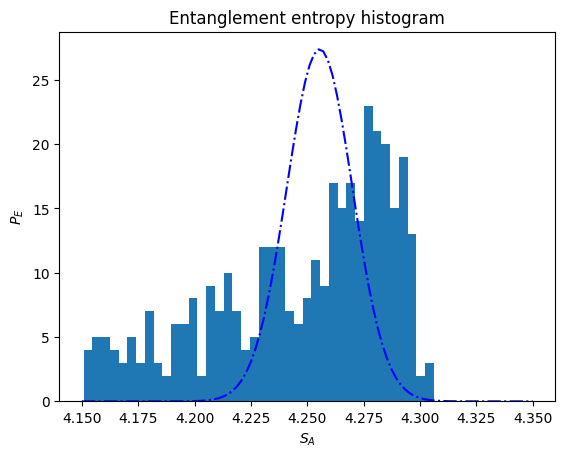

In [69]:
#We wish to plot a histogram of the entanglement entropy. First we filter the entanglement entropy list to remove the outliers (values outside the range [4.15, 4.35])

entanglement_entropy_list = np.loadtxt(f'ee_mfim__N=14,Na=7,h=0.30,g=1.08,a=7927,b=8527.txt')
ee_filtered = []
for i in range(len(entanglement_entropy_list)):
    if entanglement_entropy_list[i] > 4.15 and entanglement_entropy_list[i] < 4.35:
        ee_filtered.append(entanglement_entropy_list[i])

plt.hist(ee_filtered, bins=40)
plt.xlabel(r'$S_A$')
plt.ylabel(r'$P_E$')
plt.title('Entanglement entropy histogram')

##Let us plot the BD distribution on top

x = np.linspace(4.15,4.35,100)
mu = mu_BD(f,L,m=0.5) #4.2652
sigma = np.sqrt(2)*0.0103

plt.plot(x, gaussian(x, mu, sigma), 'b-.', label='BD')
plt.show()


In [49]:
### Next, we make a two-layered Floquet random circuit, with random two-qubit unitaries in the first layer (even sites) and second-layer (odd sites). we will convert qutip's random haar unitary to Qiskit for this
def rand_unitary_haar(n):
    """
    Returns a Haar random unitary matrix of dimension
    ``dim``, using the algorithm of [Mez07]_.

    Parameters
    ----------
    N : int
        Dimension of the unitary to be returned.

    generator : numpy.random.generator
        Random number generator.

    Returns
    -------
    U : qutip.core.data.Dense
        Unitary of shape ``(N, N)`` drawn from the Haar measure.
    """
    # Mez01 STEP 1: Generate an N × N matrix Z of complex standard
    #               normal random variates.
    Z = np.random.normal(size=(n, n)) + 1j * np.random.normal(size=(n, n))
    Z = np.array(Z, dtype=np.complex128)

    # Mez01 STEP 2: Find a QR decomposition Z = Q · R.
    Q, R = scipy.linalg.qr(Z)

    # Mez01 STEP 3: Create a diagonal matrix Lambda by rescaling
    #               the diagonal elements of R.
    Lambda = np.diag(R).copy()
    Lambda /= np.abs(Lambda)

    # Mez01 STEP 4: Note that R' := Λ¯¹ · R has real and
    #               strictly positive elements, such that
    #               Q' = Q · Λ is Haar distributed.
    # NOTE: Λ is a diagonal matrix, represented as a vector
    #       of the diagonal entries. Thus, the matrix dot product
    #       is represented nicely by the NumPy broadcasting of
    #       the *scalar* multiplication. In particular,
    #       Q · Λ = Q_ij Λ_jk = Q_ij δ_jk λ_k = Q_ij λ_j.
    #       As NumPy arrays, Q has shape (N, N) and
    #       Lambda has shape (N, ), such that the broadcasting
    #       represents precisely Q_ij λ_j.
    return Q * Lambda

def haar_unitary(n):
    """
    Generate a random Haar unitary for n qubits
    """
    U = rand_unitary_haar(2**n)
    #Convert U to numpy array
    #U = np.array(U.full())
    return U

def floquet_circuit(N,N_A,width,iterations = 50):

    f = N_A/N
    """
    Generate a two-layered Floquet circuit with random Haar unitaries
    INPUT
    U : random Haar unitary
    n : number of qubits
    RETURN
    circuit : Qiskit circuit
    
    """
    fin_ee_list = [0]*width
    for i in range(iterations):
        a,b =0,0
        circuit = QuantumCircuit(N)
        for i in range(N):
            if i % 2 == 0:
                circuit.unitary(haar_unitary(2), [i, (i+1)%N], label=r'$U_h$')
            else:
                circuit.unitary(haar_unitary(2), [i, (i+1)%N], label=r'$U_h$')
        
        #Convert circuit to matrix, find the eigenvalues and eigenvectors
        Uf = Operator(circuit)
        Uf = np.array(Uf.data)
        #print('Uf', Uf)
        eigvals, eigvecs = np.linalg.eig(Uf)
        eigvals = -np.angle(eigvals)
        #print('eigvals', eigvals)

        # Get the sorted indices of eigenvalues
        sorted_indices = np.argsort(eigvals)

        # Sort eigenvalues and eigenvectors accordingly
        eigvals_sorted = eigvals[sorted_indices]
        eigvecs_sorted = eigvecs[:, sorted_indices]
        index = np.argmin(np.abs(eigvals_sorted)) 

        print(index)
        print('eigvals_sorted', eigvals_sorted)

        a = index - int(width/2)
        b = index + int(width/2)

        print('a,b:', a,b)

        reduced_dm_list = reduced_dm(N_A,N,eigvecs_sorted, a, b)
        entanglement_entropy_list = entanglement_entropy(reduced_dm_list, alpha = 1)
        #print(len(entanglement_entropy_list))
        ##Add the ee_list values to the final list
        for j in range(len(entanglement_entropy_list)):
            fin_ee_list[j] += entanglement_entropy_list[j]
    #Normalize the final list
    for j in range(len(fin_ee_list)):
        fin_ee_list[j] /= iterations
    #Save the final list
    np.savetxt(f'ee_floquet_N={N},Na={N_A},iterations={iterations}.txt', fin_ee_list)


    

In [ ]:
##Let us run for a small state
floquet_circuit(12,6,400,iterations = 50)

2047
eigvals_sorted [-3.14086152 -3.13991401 -3.13862188 ...  3.13678349  3.13911093
  3.14156024]
a,b: 1947 2147
2046
eigvals_sorted [-3.14036206 -3.13939356 -3.13777864 ...  3.13795818  3.14009247
  3.14135876]
a,b: 1946 2146
2047
eigvals_sorted [-3.14023385 -3.13953549 -3.13791749 ...  3.13751164  3.13848148
  3.14005479]
a,b: 1947 2147
2046
eigvals_sorted [-3.13958934 -3.13767256 -3.13716401 ...  3.13803711  3.14034957
  3.14122401]
a,b: 1946 2146
2048
eigvals_sorted [-3.1405104  -3.13793751 -3.13721486 ...  3.13885448  3.13925026
  3.1404908 ]
a,b: 1948 2148
2047
eigvals_sorted [-3.14070979 -3.13993884 -3.13797089 ...  3.13774128  3.13981149
  3.14140545]
a,b: 1947 2147
2047
eigvals_sorted [-3.14071874 -3.13948328 -3.1375871  ...  3.13843155  3.13922154
  3.14094412]
a,b: 1947 2147
2046
eigvals_sorted [-3.14115116 -3.13851162 -3.13763929 ...  3.13810209  3.13910206
  3.14047118]
a,b: 1946 2146
2047
eigvals_sorted [-3.13890537 -3.13794719 -3.13590192 ...  3.13918564  3.14023795
  3

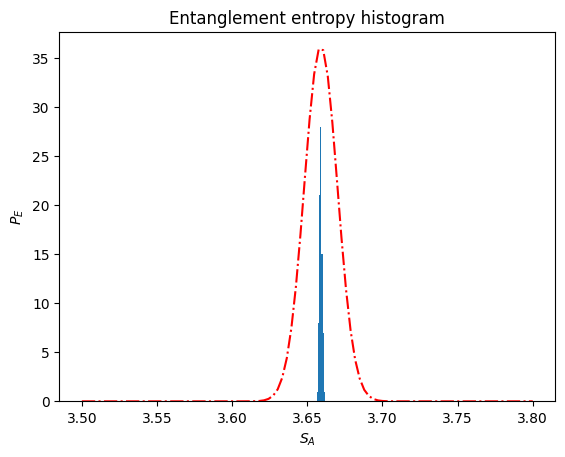

In [60]:
##Now, we plot the histogram from the saved file

ee_floquet = np.loadtxt(f'ee_floquet_N=12,Na=6,iterations=50.txt')
plt.hist(ee_floquet, bins=20)
plt.xlabel(r'$S_A$')
plt.ylabel(r'$P_E$')
plt.title('Entanglement entropy histogram')

##Let us plot the page distribution on top
x = np.linspace(3.5,3.8,100)
mu = 3.6590
sigma = np.sqrt(2)*0.0078
plt.plot(x, gaussian(x, mu, sigma), 'r-.', label='Page')
